# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


In [3]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

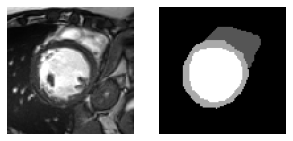

(96, 96)


In [4]:

import os
import cv2 #import OpenCV

data_dir = '/content/drive/MyDrive/data/train/'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [5]:

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels, mid_channels = None):
    if not mid_channels:
            mid_channels = out_channels
    return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = double_conv(1,3)       
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       # self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

class CNNSEG(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 3)
        self.dconv_down2 = double_conv(3, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)          

        self.maxpool = nn.MaxPool2d(2) #kernel size two..stride = none

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        
       # self.dconv_up3 = double_conv(256 + 512, 256)
        #self.dconv_up2 = double_conv(128 + 256, 128)
        #self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up4 = double_conv(512+512, 512)
        self.dconv_up3 = double_conv()
        self.dconv_up2 = double_conv(512+512, 512)
        self.dconv_up1 = double_conv(512+512, 512)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 

        conv5 = self.dconv_down5(x)

        x = self.upsample(conv5)        #left with 512 channels and ..becomes 12 * 12
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


#https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model = UNet() # We can now create a model using your defined segmentation model

In [7]:



model = model.to(device)

model

UNet(
  (dconv_pre): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [8]:
from torchsummary import  summary
#help to view the visualisation of the model

summary(model,input_size=(1,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 96, 96]              30
       BatchNorm2d-2            [-1, 3, 96, 96]               6
              ReLU-3            [-1, 3, 96, 96]               0
            Conv2d-4            [-1, 3, 96, 96]              84
       BatchNorm2d-5            [-1, 3, 96, 96]               6
              ReLU-6            [-1, 3, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]           1,792
       BatchNorm2d-8           [-1, 64, 96, 96]             128
              ReLU-9           [-1, 64, 96, 96]               0
           Conv2d-10           [-1, 64, 96, 96]          36,928
      BatchNorm2d-11           [-1, 64, 96, 96]             128
             ReLU-12           [-1, 64, 96, 96]               0
        MaxPool2d-13           [-1, 64, 48, 48]               0
           Conv2d-14          [-1, 128,

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [9]:

import torch.optim as optim
from torch.optim import lr_scheduler

"""
def dice_loss(pred,target, smooth = 1.):

    pred = pred.contiguous()
    target = target.contiguous()    
    
    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().

    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


criterion = nn.CrossEntropyLoss()

# so we have two types of loss the dice loss and cross entropy loss

def optimizer():
  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)

optimizer_ft = optimizer()
def exp_lr_scheduler():
  return lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)
"""


"\ndef dice_loss(pred,target, smooth = 1.):\n\n    pred = pred.contiguous()\n    target = target.contiguous()    \n    \n    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.\n\n    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().\n\n    \n\n    intersection = (pred * target).sum(dim=2).sum(dim=2)\n    \n    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))\n    \n    return loss.mean()\n\n\ncriterion = nn.CrossEntropyLoss()\n\n# so we have two types of loss the dice loss and cross entropy loss\n\ndef optimizer():\n  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)\n\noptimiz

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [10]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


Epoch 1/10: 3img [00:00, 10.22img/s, loss (batch)=0.0934]

train loss 0.060138966888189316  step : 1  epoch : 0
train loss 0.06563027948141098  step : 2  epoch : 0
train loss 0.0933690071105957  step : 3  epoch : 0


Epoch 1/10: 7img [00:00, 12.35img/s, loss (batch)=0.0786]

train loss 0.07251831144094467  step : 4  epoch : 0
train loss 0.06552190333604813  step : 5  epoch : 0
train loss 0.07857470214366913  step : 6  epoch : 0


Epoch 1/10: 10img [00:00, 13.19img/s, loss (batch)=0.0749]

train loss 0.07534971088171005  step : 7  epoch : 0
train loss 0.0662911981344223  step : 8  epoch : 0
train loss 0.12590259313583374  step : 9  epoch : 0
train loss 0.07494130730628967  step : 10  epoch : 0


Epoch 1/10: 14img [00:01, 14.24img/s, loss (batch)=0.0884]

train loss 0.09745998680591583  step : 11  epoch : 0
train loss 0.17170584201812744  step : 12  epoch : 0
train loss 0.10572695732116699  step : 13  epoch : 0
train loss 0.088395856320858  step : 14  epoch : 0


Epoch 1/10: 18img [00:01, 15.19img/s, loss (batch)=0.0715]

train loss 0.07566318660974503  step : 15  epoch : 0
train loss 0.09231780469417572  step : 16  epoch : 0
train loss 0.08458280563354492  step : 17  epoch : 0
train loss 0.07145825773477554  step : 18  epoch : 0


Epoch 1/10: 22img [00:01, 15.60img/s, loss (batch)=0.0752]

train loss 0.07212790101766586  step : 19  epoch : 0
train loss 0.0762251541018486  step : 20  epoch : 0
train loss 0.09061150252819061  step : 21  epoch : 0
train loss 0.07517295330762863  step : 22  epoch : 0


Epoch 1/10: 26img [00:01, 15.27img/s, loss (batch)=0.0724]

train loss 0.087374746799469  step : 23  epoch : 0
train loss 0.1101876050233841  step : 24  epoch : 0
train loss 0.1678001880645752  step : 25  epoch : 0
train loss 0.07242178916931152  step : 26  epoch : 0


Epoch 1/10: 30img [00:02, 15.41img/s, loss (batch)=0.0685]

train loss 0.07728073000907898  step : 27  epoch : 0
train loss 0.07212767750024796  step : 28  epoch : 0
train loss 0.07540000975131989  step : 29  epoch : 0
train loss 0.06849374622106552  step : 30  epoch : 0


Epoch 1/10: 34img [00:02, 15.92img/s, loss (batch)=0.0827]

train loss 0.07794325053691864  step : 31  epoch : 0
train loss 0.08769933134317398  step : 32  epoch : 0
train loss 0.09992459416389465  step : 33  epoch : 0
train loss 0.08269704133272171  step : 34  epoch : 0


Epoch 1/10: 38img [00:02, 16.02img/s, loss (batch)=0.0744]

train loss 0.10891751945018768  step : 35  epoch : 0
train loss 0.09933998435735703  step : 36  epoch : 0
train loss 0.08828521519899368  step : 37  epoch : 0
train loss 0.07441116869449615  step : 38  epoch : 0


Epoch 1/10: 42img [00:02, 16.34img/s, loss (batch)=0.067]

train loss 0.08917746692895889  step : 39  epoch : 0
train loss 0.0940004512667656  step : 40  epoch : 0
train loss 0.0599505752325058  step : 41  epoch : 0
train loss 0.06696364283561707  step : 42  epoch : 0


Epoch 1/10: 46img [00:03, 15.92img/s, loss (batch)=0.12]  

train loss 0.0710839033126831  step : 43  epoch : 0
train loss 0.10122299939393997  step : 44  epoch : 0
train loss 0.0815061703324318  step : 45  epoch : 0
train loss 0.12011945992708206  step : 46  epoch : 0


Epoch 1/10: 50img [00:03, 16.17img/s, loss (batch)=0.0777]

train loss 0.06155340373516083  step : 47  epoch : 0
train loss 0.06358727812767029  step : 48  epoch : 0
train loss 0.08556545525789261  step : 49  epoch : 0
train loss 0.07766781747341156  step : 50  epoch : 0


Epoch 1/10: 54img [00:03, 16.21img/s, loss (batch)=0.0718]

train loss 0.06545864790678024  step : 51  epoch : 0
train loss 0.08423581719398499  step : 52  epoch : 0
train loss 0.06627008318901062  step : 53  epoch : 0
train loss 0.07180400937795639  step : 54  epoch : 0


Epoch 1/10: 58img [00:03, 16.25img/s, loss (batch)=0.0775]

train loss 0.07741952687501907  step : 55  epoch : 0
train loss 0.08553282171487808  step : 56  epoch : 0
train loss 0.08827109634876251  step : 57  epoch : 0
train loss 0.07749120146036148  step : 58  epoch : 0


Epoch 1/10: 62img [00:04, 16.07img/s, loss (batch)=0.0683]

train loss 0.06438690423965454  step : 59  epoch : 0
train loss 0.06981818377971649  step : 60  epoch : 0
train loss 0.08560161292552948  step : 61  epoch : 0
train loss 0.06829611212015152  step : 62  epoch : 0


Epoch 1/10: 66img [00:04, 16.14img/s, loss (batch)=0.0844]

train loss 0.08639571070671082  step : 63  epoch : 0
train loss 0.06761093437671661  step : 64  epoch : 0
train loss 0.07082252949476242  step : 65  epoch : 0
train loss 0.0843997448682785  step : 66  epoch : 0


Epoch 1/10: 70img [00:04, 16.26img/s, loss (batch)=0.067] 

train loss 0.08310294151306152  step : 67  epoch : 0
train loss 0.22770361602306366  step : 68  epoch : 0
train loss 0.07517944276332855  step : 69  epoch : 0
train loss 0.0669751986861229  step : 70  epoch : 0


Epoch 1/10: 74img [00:04, 16.35img/s, loss (batch)=0.0704]

train loss 0.06698594987392426  step : 71  epoch : 0
train loss 0.1793675273656845  step : 72  epoch : 0
train loss 0.07636632025241852  step : 73  epoch : 0
train loss 0.07040482759475708  step : 74  epoch : 0


Epoch 1/10: 78img [00:05, 16.75img/s, loss (batch)=0.0626]

train loss 0.08980338275432587  step : 75  epoch : 0
train loss 0.06276535242795944  step : 76  epoch : 0
train loss 0.07326163351535797  step : 77  epoch : 0
train loss 0.06260563433170319  step : 78  epoch : 0


Epoch 1/10: 82img [00:05, 16.59img/s, loss (batch)=0.0693]

train loss 0.17460641264915466  step : 79  epoch : 0
train loss 0.0782831609249115  step : 80  epoch : 0
train loss 0.07427526265382767  step : 81  epoch : 0
train loss 0.06926560401916504  step : 82  epoch : 0


Epoch 1/10: 86img [00:05, 16.31img/s, loss (batch)=0.0613]

train loss 0.08227898925542831  step : 83  epoch : 0
train loss 0.07982811331748962  step : 84  epoch : 0
train loss 0.11155546456575394  step : 85  epoch : 0
train loss 0.06125231087207794  step : 86  epoch : 0


Epoch 1/10: 90img [00:05, 16.29img/s, loss (batch)=0.354] 

train loss 0.08232682943344116  step : 87  epoch : 0
train loss 0.06810036301612854  step : 88  epoch : 0
train loss 0.0669042244553566  step : 89  epoch : 0
train loss 0.35433393716812134  step : 90  epoch : 0


Epoch 1/10: 94img [00:06, 16.22img/s, loss (batch)=0.0599]

train loss 0.06298559159040451  step : 91  epoch : 0
train loss 0.1021474301815033  step : 92  epoch : 0
train loss 0.08201020956039429  step : 93  epoch : 0
train loss 0.059930525720119476  step : 94  epoch : 0


Epoch 1/10: 98img [00:06, 16.54img/s, loss (batch)=0.0738]

train loss 0.07376834750175476  step : 95  epoch : 0
train loss 0.07703941315412521  step : 96  epoch : 0
train loss 0.06742390990257263  step : 97  epoch : 0
train loss 0.07384815812110901  step : 98  epoch : 0


Epoch 1/10: 100img [00:06, 15.56img/s, loss (batch)=0.0663]


train loss 0.07717649638652802  step : 99  epoch : 0
train loss 0.06633651256561279  step : 100  epoch : 0


Epoch 2/10: 4img [00:00, 13.44img/s, loss (batch)=0.0635]

train loss 0.06564556807279587  step : 101  epoch : 1
train loss 0.09429419040679932  step : 102  epoch : 1
train loss 0.06637286394834518  step : 103  epoch : 1
train loss 0.0634654313325882  step : 104  epoch : 1


Epoch 2/10: 8img [00:00, 15.43img/s, loss (batch)=0.0632]

train loss 0.07435956597328186  step : 105  epoch : 1
train loss 0.09275612235069275  step : 106  epoch : 1
train loss 0.08302148431539536  step : 107  epoch : 1
train loss 0.0632232129573822  step : 108  epoch : 1


Epoch 2/10: 12img [00:00, 15.93img/s, loss (batch)=0.0861]

train loss 0.06809177249670029  step : 109  epoch : 1
train loss 0.07861362397670746  step : 110  epoch : 1
train loss 0.06717194616794586  step : 111  epoch : 1
train loss 0.08610373735427856  step : 112  epoch : 1


Epoch 2/10: 16img [00:01, 16.22img/s, loss (batch)=0.0871]

train loss 0.05868523567914963  step : 113  epoch : 1
train loss 0.06109403073787689  step : 114  epoch : 1
train loss 0.08498179167509079  step : 115  epoch : 1
train loss 0.08707863092422485  step : 116  epoch : 1


Epoch 2/10: 20img [00:01, 16.52img/s, loss (batch)=0.0707]

train loss 0.241646409034729  step : 117  epoch : 1
train loss 0.0611778162419796  step : 118  epoch : 1
train loss 0.06988979876041412  step : 119  epoch : 1
train loss 0.07069917768239975  step : 120  epoch : 1


Epoch 2/10: 24img [00:01, 16.53img/s, loss (batch)=0.0603]

train loss 0.07719109952449799  step : 121  epoch : 1
train loss 0.06911519914865494  step : 122  epoch : 1
train loss 0.06139492243528366  step : 123  epoch : 1
train loss 0.06029674783349037  step : 124  epoch : 1


Epoch 2/10: 28img [00:01, 16.40img/s, loss (batch)=0.0773]

train loss 0.07018718868494034  step : 125  epoch : 1
train loss 0.07164136320352554  step : 126  epoch : 1
train loss 0.06406304240226746  step : 127  epoch : 1
train loss 0.07730185240507126  step : 128  epoch : 1


Epoch 2/10: 32img [00:02, 16.61img/s, loss (batch)=0.0783]

train loss 0.06301458179950714  step : 129  epoch : 1
train loss 0.0663919672369957  step : 130  epoch : 1
train loss 0.15189699828624725  step : 131  epoch : 1
train loss 0.07831600308418274  step : 132  epoch : 1


Epoch 2/10: 36img [00:02, 16.55img/s, loss (batch)=0.113]

train loss 0.06467770785093307  step : 133  epoch : 1
train loss 0.05777207762002945  step : 134  epoch : 1
train loss 0.08896207809448242  step : 135  epoch : 1
train loss 0.1134549230337143  step : 136  epoch : 1


Epoch 2/10: 40img [00:02, 16.36img/s, loss (batch)=0.0679]

train loss 0.08723185211420059  step : 137  epoch : 1
train loss 0.06514962017536163  step : 138  epoch : 1
train loss 0.06613098829984665  step : 139  epoch : 1
train loss 0.06786611676216125  step : 140  epoch : 1


Epoch 2/10: 44img [00:02, 16.14img/s, loss (batch)=0.0649]

train loss 0.3578527271747589  step : 141  epoch : 1
train loss 0.0684085339307785  step : 142  epoch : 1
train loss 0.08084609359502792  step : 143  epoch : 1
train loss 0.06494930386543274  step : 144  epoch : 1


Epoch 2/10: 48img [00:02, 16.20img/s, loss (batch)=0.0819]

train loss 0.27981141209602356  step : 145  epoch : 1
train loss 0.06553542613983154  step : 146  epoch : 1
train loss 0.06590218096971512  step : 147  epoch : 1
train loss 0.08194620907306671  step : 148  epoch : 1


Epoch 2/10: 52img [00:03, 16.25img/s, loss (batch)=0.142] 

train loss 0.07432831823825836  step : 149  epoch : 1
train loss 0.08840282261371613  step : 150  epoch : 1
train loss 0.07027165591716766  step : 151  epoch : 1
train loss 0.14201290905475616  step : 152  epoch : 1


Epoch 2/10: 56img [00:03, 16.10img/s, loss (batch)=0.0748]

train loss 0.061787404119968414  step : 153  epoch : 1
train loss 0.07209670543670654  step : 154  epoch : 1
train loss 0.08586381375789642  step : 155  epoch : 1
train loss 0.07482725381851196  step : 156  epoch : 1


Epoch 2/10: 60img [00:03, 16.22img/s, loss (batch)=0.0747]

train loss 0.08087540417909622  step : 157  epoch : 1
train loss 0.07385841757059097  step : 158  epoch : 1
train loss 0.10797193646430969  step : 159  epoch : 1
train loss 0.07467114180326462  step : 160  epoch : 1


Epoch 2/10: 64img [00:03, 16.23img/s, loss (batch)=0.0694]

train loss 0.056557752192020416  step : 161  epoch : 1
train loss 0.1145138368010521  step : 162  epoch : 1
train loss 0.07388262450695038  step : 163  epoch : 1
train loss 0.06936778128147125  step : 164  epoch : 1


Epoch 2/10: 68img [00:04, 16.40img/s, loss (batch)=0.0968]

train loss 0.06803229451179504  step : 165  epoch : 1
train loss 0.09812167286872864  step : 166  epoch : 1
train loss 0.07248897850513458  step : 167  epoch : 1
train loss 0.0967555120587349  step : 168  epoch : 1


Epoch 2/10: 72img [00:04, 15.95img/s, loss (batch)=0.0938]

train loss 0.07286535203456879  step : 169  epoch : 1
train loss 0.06683403998613358  step : 170  epoch : 1
train loss 0.0972854346036911  step : 171  epoch : 1
train loss 0.09383761882781982  step : 172  epoch : 1


Epoch 2/10: 76img [00:04, 16.10img/s, loss (batch)=0.104]

train loss 0.09243588894605637  step : 173  epoch : 1
train loss 0.10131685435771942  step : 174  epoch : 1
train loss 0.11268340796232224  step : 175  epoch : 1
train loss 0.10415724664926529  step : 176  epoch : 1


Epoch 2/10: 80img [00:04, 16.13img/s, loss (batch)=0.126] 

train loss 0.06619727611541748  step : 177  epoch : 1
train loss 0.08395622670650482  step : 178  epoch : 1
train loss 0.06507237255573273  step : 179  epoch : 1
train loss 0.1256038397550583  step : 180  epoch : 1


Epoch 2/10: 84img [00:05, 16.15img/s, loss (batch)=0.0714]

train loss 0.10365108400583267  step : 181  epoch : 1
train loss 0.06530971080064774  step : 182  epoch : 1
train loss 0.08285033702850342  step : 183  epoch : 1
train loss 0.07136007398366928  step : 184  epoch : 1


Epoch 2/10: 88img [00:05, 16.14img/s, loss (batch)=0.0818]

train loss 0.0886363685131073  step : 185  epoch : 1
train loss 0.09006022661924362  step : 186  epoch : 1
train loss 0.1995428204536438  step : 187  epoch : 1
train loss 0.08180084824562073  step : 188  epoch : 1


Epoch 2/10: 92img [00:05, 15.79img/s, loss (batch)=0.0635]

train loss 0.0733826532959938  step : 189  epoch : 1
train loss 0.06843197345733643  step : 190  epoch : 1
train loss 0.061817705631256104  step : 191  epoch : 1
train loss 0.06349138915538788  step : 192  epoch : 1


Epoch 2/10: 96img [00:05, 16.16img/s, loss (batch)=0.0774]

train loss 0.07622331380844116  step : 193  epoch : 1
train loss 0.058832988142967224  step : 194  epoch : 1
train loss 0.086037278175354  step : 195  epoch : 1
train loss 0.07744255661964417  step : 196  epoch : 1


Epoch 2/10: 100img [00:06, 16.42img/s, loss (batch)=0.0574]

train loss 0.061854586005210876  step : 197  epoch : 1
train loss 0.22675339877605438  step : 198  epoch : 1
train loss 0.06714822351932526  step : 199  epoch : 1
train loss 0.057417549192905426  step : 200  epoch : 1


Epoch 2/10: 100img [00:06, 15.97img/s, loss (batch)=0.0574]
Epoch 3/10: 4img [00:00, 12.94img/s, loss (batch)=0.0684]

train loss 0.056758806109428406  step : 201  epoch : 2
train loss 0.08143200725317001  step : 202  epoch : 2
train loss 0.06722422689199448  step : 203  epoch : 2
train loss 0.06843476742506027  step : 204  epoch : 2


Epoch 3/10: 8img [00:00, 15.29img/s, loss (batch)=0.0636]

train loss 0.06856140494346619  step : 205  epoch : 2
train loss 0.06489592790603638  step : 206  epoch : 2
train loss 0.06933164596557617  step : 207  epoch : 2
train loss 0.06355112791061401  step : 208  epoch : 2


Epoch 3/10: 12img [00:00, 15.82img/s, loss (batch)=0.0651]

train loss 0.06832598894834518  step : 209  epoch : 2
train loss 0.06880779564380646  step : 210  epoch : 2
train loss 0.05489048734307289  step : 211  epoch : 2
train loss 0.06513632833957672  step : 212  epoch : 2


Epoch 3/10: 16img [00:01, 15.63img/s, loss (batch)=0.0939]

train loss 0.06551027297973633  step : 213  epoch : 2
train loss 0.09553990513086319  step : 214  epoch : 2
train loss 0.07394442707300186  step : 215  epoch : 2
train loss 0.09392862766981125  step : 216  epoch : 2


Epoch 3/10: 20img [00:01, 15.85img/s, loss (batch)=0.0616]

train loss 0.06153624504804611  step : 217  epoch : 2
train loss 0.07459843158721924  step : 218  epoch : 2
train loss 0.07706594467163086  step : 219  epoch : 2
train loss 0.061565548181533813  step : 220  epoch : 2


Epoch 3/10: 24img [00:01, 15.94img/s, loss (batch)=0.0689]

train loss 0.06658071279525757  step : 221  epoch : 2
train loss 0.06490477919578552  step : 222  epoch : 2
train loss 0.13394510746002197  step : 223  epoch : 2
train loss 0.06889060884714127  step : 224  epoch : 2


Epoch 3/10: 28img [00:01, 16.45img/s, loss (batch)=0.0643]

train loss 0.2336488515138626  step : 225  epoch : 2
train loss 0.08017808198928833  step : 226  epoch : 2
train loss 0.06528804451227188  step : 227  epoch : 2
train loss 0.06432607769966125  step : 228  epoch : 2


Epoch 3/10: 32img [00:02, 16.34img/s, loss (batch)=0.073] 

train loss 0.1725633293390274  step : 229  epoch : 2
train loss 0.06724164634943008  step : 230  epoch : 2
train loss 0.07223866879940033  step : 231  epoch : 2
train loss 0.07304047048091888  step : 232  epoch : 2


Epoch 3/10: 36img [00:02, 15.85img/s, loss (batch)=0.0616]

train loss 0.08639411628246307  step : 233  epoch : 2
train loss 0.07782838493585587  step : 234  epoch : 2
train loss 0.08683314919471741  step : 235  epoch : 2
train loss 0.061556026339530945  step : 236  epoch : 2


Epoch 3/10: 40img [00:02, 16.13img/s, loss (batch)=0.0843]

train loss 0.08840958774089813  step : 237  epoch : 2
train loss 0.07542858272790909  step : 238  epoch : 2
train loss 0.06446895748376846  step : 239  epoch : 2
train loss 0.0843355804681778  step : 240  epoch : 2


Epoch 3/10: 44img [00:02, 16.01img/s, loss (batch)=0.0734]

train loss 0.06203453987836838  step : 241  epoch : 2
train loss 0.07767122238874435  step : 242  epoch : 2
train loss 0.062399424612522125  step : 243  epoch : 2
train loss 0.07335036993026733  step : 244  epoch : 2


Epoch 3/10: 48img [00:03, 16.23img/s, loss (batch)=0.0768]

train loss 0.06036379560828209  step : 245  epoch : 2
train loss 0.06168295443058014  step : 246  epoch : 2
train loss 0.06303270161151886  step : 247  epoch : 2
train loss 0.07677360624074936  step : 248  epoch : 2


Epoch 3/10: 52img [00:03, 16.08img/s, loss (batch)=0.058]

train loss 0.08832210302352905  step : 249  epoch : 2
train loss 0.09363602101802826  step : 250  epoch : 2
train loss 0.06398394703865051  step : 251  epoch : 2
train loss 0.05803953856229782  step : 252  epoch : 2


Epoch 3/10: 56img [00:03, 15.65img/s, loss (batch)=0.0631]

train loss 0.06148647889494896  step : 253  epoch : 2
train loss 0.06029501557350159  step : 254  epoch : 2
train loss 0.06642891466617584  step : 255  epoch : 2
train loss 0.0630711242556572  step : 256  epoch : 2


Epoch 3/10: 60img [00:03, 15.87img/s, loss (batch)=0.0914]

train loss 0.05922608822584152  step : 257  epoch : 2
train loss 0.34539446234703064  step : 258  epoch : 2
train loss 0.07152178883552551  step : 259  epoch : 2
train loss 0.09137792140245438  step : 260  epoch : 2


Epoch 3/10: 64img [00:04, 16.10img/s, loss (batch)=0.0552]

train loss 0.0643516257405281  step : 261  epoch : 2
train loss 0.07213252782821655  step : 262  epoch : 2
train loss 0.10678629577159882  step : 263  epoch : 2
train loss 0.05523214116692543  step : 264  epoch : 2


Epoch 3/10: 68img [00:04, 16.10img/s, loss (batch)=0.0557]

train loss 0.06355743110179901  step : 265  epoch : 2
train loss 0.0997217670083046  step : 266  epoch : 2
train loss 0.05836081504821777  step : 267  epoch : 2
train loss 0.05571781098842621  step : 268  epoch : 2


Epoch 3/10: 72img [00:04, 15.57img/s, loss (batch)=0.0744]

train loss 0.06542156636714935  step : 269  epoch : 2
train loss 0.05935200676321983  step : 270  epoch : 2
train loss 0.07114779204130173  step : 271  epoch : 2
train loss 0.07442082464694977  step : 272  epoch : 2


Epoch 3/10: 76img [00:04, 15.76img/s, loss (batch)=0.0698]

train loss 0.06189306080341339  step : 273  epoch : 2
train loss 0.07372798025608063  step : 274  epoch : 2
train loss 0.19218973815441132  step : 275  epoch : 2
train loss 0.06982764601707458  step : 276  epoch : 2


Epoch 3/10: 80img [00:05, 15.76img/s, loss (batch)=0.0608]

train loss 0.05855664238333702  step : 277  epoch : 2
train loss 0.05540618672966957  step : 278  epoch : 2
train loss 0.06999821215867996  step : 279  epoch : 2
train loss 0.06075095385313034  step : 280  epoch : 2


Epoch 3/10: 84img [00:05, 15.77img/s, loss (batch)=0.0706]

train loss 0.08912716060876846  step : 281  epoch : 2
train loss 0.05911356955766678  step : 282  epoch : 2
train loss 0.05628064647316933  step : 283  epoch : 2
train loss 0.07058808207511902  step : 284  epoch : 2


Epoch 3/10: 88img [00:05, 15.92img/s, loss (batch)=0.0584]

train loss 0.06936696171760559  step : 285  epoch : 2
train loss 0.12748050689697266  step : 286  epoch : 2
train loss 0.07717133313417435  step : 287  epoch : 2
train loss 0.05837336927652359  step : 288  epoch : 2


Epoch 3/10: 92img [00:05, 16.05img/s, loss (batch)=0.0758]

train loss 0.06302809715270996  step : 289  epoch : 2
train loss 0.05914050713181496  step : 290  epoch : 2
train loss 0.06924372166395187  step : 291  epoch : 2
train loss 0.07580002397298813  step : 292  epoch : 2


Epoch 3/10: 96img [00:06, 15.85img/s, loss (batch)=0.0781]

train loss 0.07480346411466599  step : 293  epoch : 2
train loss 0.08391111344099045  step : 294  epoch : 2
train loss 0.07447082549333572  step : 295  epoch : 2
train loss 0.07813975214958191  step : 296  epoch : 2


Epoch 3/10: 100img [00:06, 16.43img/s, loss (batch)=0.123]

train loss 0.08757200837135315  step : 297  epoch : 2
train loss 0.08337333053350449  step : 298  epoch : 2
train loss 0.06866567581892014  step : 299  epoch : 2
train loss 0.12269804626703262  step : 300  epoch : 2


Epoch 3/10: 100img [00:06, 15.69img/s, loss (batch)=0.123]
Epoch 4/10: 4img [00:00, 13.19img/s, loss (batch)=0.0574]

train loss 0.07612742483615875  step : 301  epoch : 3
train loss 0.06068810820579529  step : 302  epoch : 3
train loss 0.05783742666244507  step : 303  epoch : 3
train loss 0.05743366479873657  step : 304  epoch : 3


Epoch 4/10: 8img [00:00, 15.54img/s, loss (batch)=0.0689]

train loss 0.06092310696840286  step : 305  epoch : 3
train loss 0.05435324087738991  step : 306  epoch : 3
train loss 0.08146697282791138  step : 307  epoch : 3
train loss 0.06891262531280518  step : 308  epoch : 3


Epoch 4/10: 12img [00:00, 15.93img/s, loss (batch)=0.0631]

train loss 0.10177428275346756  step : 309  epoch : 3
train loss 0.05856337398290634  step : 310  epoch : 3
train loss 0.05742193013429642  step : 311  epoch : 3
train loss 0.06313692778348923  step : 312  epoch : 3


Epoch 4/10: 16img [00:01, 16.03img/s, loss (batch)=0.0614]

train loss 0.074163056910038  step : 313  epoch : 3
train loss 0.07015853375196457  step : 314  epoch : 3
train loss 0.06468169391155243  step : 315  epoch : 3
train loss 0.06144172325730324  step : 316  epoch : 3


Epoch 4/10: 20img [00:01, 15.71img/s, loss (batch)=0.0567]

train loss 0.06671027094125748  step : 317  epoch : 3
train loss 0.06594103574752808  step : 318  epoch : 3
train loss 0.06927350908517838  step : 319  epoch : 3
train loss 0.056732162833213806  step : 320  epoch : 3


Epoch 4/10: 24img [00:01, 15.69img/s, loss (batch)=0.0645]

train loss 0.07564489543437958  step : 321  epoch : 3
train loss 0.06096179783344269  step : 322  epoch : 3
train loss 0.058002907782793045  step : 323  epoch : 3
train loss 0.06448541581630707  step : 324  epoch : 3


Epoch 4/10: 28img [00:01, 15.85img/s, loss (batch)=0.0688]

train loss 0.06463482975959778  step : 325  epoch : 3
train loss 0.05842175707221031  step : 326  epoch : 3
train loss 0.06713703274726868  step : 327  epoch : 3
train loss 0.06880031526088715  step : 328  epoch : 3


Epoch 4/10: 32img [00:02, 15.96img/s, loss (batch)=0.0751]

train loss 0.1268242448568344  step : 329  epoch : 3
train loss 0.05539752542972565  step : 330  epoch : 3
train loss 0.05751677602529526  step : 331  epoch : 3
train loss 0.07505954802036285  step : 332  epoch : 3


Epoch 4/10: 36img [00:02, 16.35img/s, loss (batch)=0.0614]

train loss 0.0708138644695282  step : 333  epoch : 3
train loss 0.07323041558265686  step : 334  epoch : 3
train loss 0.05735934153199196  step : 335  epoch : 3
train loss 0.06135369837284088  step : 336  epoch : 3


Epoch 4/10: 40img [00:02, 16.43img/s, loss (batch)=0.0841]

train loss 0.06143399327993393  step : 337  epoch : 3
train loss 0.07378341257572174  step : 338  epoch : 3
train loss 0.07036546617746353  step : 339  epoch : 3
train loss 0.0841493010520935  step : 340  epoch : 3


Epoch 4/10: 44img [00:02, 16.59img/s, loss (batch)=0.0623]

train loss 0.06969139724969864  step : 341  epoch : 3
train loss 0.06833390146493912  step : 342  epoch : 3
train loss 0.08184821158647537  step : 343  epoch : 3
train loss 0.06225470080971718  step : 344  epoch : 3


Epoch 4/10: 48img [00:03, 15.81img/s, loss (batch)=0.0727]

train loss 0.20346379280090332  step : 345  epoch : 3
train loss 0.06533624976873398  step : 346  epoch : 3
train loss 0.05486823618412018  step : 347  epoch : 3
train loss 0.0727212131023407  step : 348  epoch : 3


Epoch 4/10: 52img [00:03, 15.47img/s, loss (batch)=0.0826]

train loss 0.0820489227771759  step : 349  epoch : 3
train loss 0.11650341004133224  step : 350  epoch : 3
train loss 0.06670229136943817  step : 351  epoch : 3
train loss 0.0826180949807167  step : 352  epoch : 3


Epoch 4/10: 56img [00:03, 16.08img/s, loss (batch)=0.0612]

train loss 0.08346734941005707  step : 353  epoch : 3
train loss 0.06738463789224625  step : 354  epoch : 3
train loss 0.07057727873325348  step : 355  epoch : 3
train loss 0.06120121106505394  step : 356  epoch : 3


Epoch 4/10: 60img [00:03, 15.70img/s, loss (batch)=0.0697]

train loss 0.07285106182098389  step : 357  epoch : 3
train loss 0.06891753524541855  step : 358  epoch : 3
train loss 0.08850545436143875  step : 359  epoch : 3
train loss 0.06966164708137512  step : 360  epoch : 3


Epoch 4/10: 64img [00:04, 16.05img/s, loss (batch)=0.0664]

train loss 0.057851359248161316  step : 361  epoch : 3
train loss 0.06159593164920807  step : 362  epoch : 3
train loss 0.05736805498600006  step : 363  epoch : 3
train loss 0.06640899926424026  step : 364  epoch : 3


Epoch 4/10: 68img [00:04, 15.87img/s, loss (batch)=0.067]

train loss 0.05579495429992676  step : 365  epoch : 3
train loss 0.06688566505908966  step : 366  epoch : 3
train loss 0.1650935858488083  step : 367  epoch : 3
train loss 0.06697091460227966  step : 368  epoch : 3


Epoch 4/10: 72img [00:04, 16.05img/s, loss (batch)=0.0672]

train loss 0.05412483215332031  step : 369  epoch : 3
train loss 0.05482831969857216  step : 370  epoch : 3
train loss 0.07421644032001495  step : 371  epoch : 3
train loss 0.06723488122224808  step : 372  epoch : 3


Epoch 4/10: 76img [00:04, 16.05img/s, loss (batch)=0.0616]

train loss 0.07391441613435745  step : 373  epoch : 3
train loss 0.16832253336906433  step : 374  epoch : 3
train loss 0.09303365647792816  step : 375  epoch : 3
train loss 0.06160403788089752  step : 376  epoch : 3


Epoch 4/10: 80img [00:05, 15.99img/s, loss (batch)=0.0557]

train loss 0.0600891038775444  step : 377  epoch : 3
train loss 0.058545954525470734  step : 378  epoch : 3
train loss 0.12627770006656647  step : 379  epoch : 3
train loss 0.055652834475040436  step : 380  epoch : 3


Epoch 4/10: 84img [00:05, 16.12img/s, loss (batch)=0.0836]

train loss 0.05961626395583153  step : 381  epoch : 3
train loss 0.06960737705230713  step : 382  epoch : 3
train loss 0.0588209442794323  step : 383  epoch : 3
train loss 0.08364608883857727  step : 384  epoch : 3


Epoch 4/10: 88img [00:05, 16.75img/s, loss (batch)=0.0679]

train loss 0.0789964497089386  step : 385  epoch : 3
train loss 0.078957699239254  step : 386  epoch : 3
train loss 0.08013223111629486  step : 387  epoch : 3
train loss 0.06793978810310364  step : 388  epoch : 3


Epoch 4/10: 92img [00:05, 17.20img/s, loss (batch)=0.0706]

train loss 0.3406263291835785  step : 389  epoch : 3
train loss 0.06172148138284683  step : 390  epoch : 3
train loss 0.061321958899497986  step : 391  epoch : 3
train loss 0.07062944024801254  step : 392  epoch : 3


Epoch 4/10: 96img [00:06, 16.90img/s, loss (batch)=0.0742]

train loss 0.05942792072892189  step : 393  epoch : 3
train loss 0.05933089554309845  step : 394  epoch : 3
train loss 0.06290967017412186  step : 395  epoch : 3
train loss 0.07415743917226791  step : 396  epoch : 3


Epoch 4/10: 100img [00:06, 16.89img/s, loss (batch)=0.0541]

train loss 0.09507008641958237  step : 397  epoch : 3
train loss 0.05922824144363403  step : 398  epoch : 3
train loss 0.06124655902385712  step : 399  epoch : 3
train loss 0.054105244576931  step : 400  epoch : 3


Epoch 4/10: 100img [00:06, 15.87img/s, loss (batch)=0.0541]
Epoch 5/10: 4img [00:00, 13.50img/s, loss (batch)=0.0534]

train loss 0.0807855948805809  step : 401  epoch : 4
train loss 0.08742714673280716  step : 402  epoch : 4
train loss 0.06553613394498825  step : 403  epoch : 4
train loss 0.05342041328549385  step : 404  epoch : 4


Epoch 5/10: 8img [00:00, 15.79img/s, loss (batch)=0.0737]

train loss 0.065555639564991  step : 405  epoch : 4
train loss 0.05580180138349533  step : 406  epoch : 4
train loss 0.05273507535457611  step : 407  epoch : 4
train loss 0.07369811832904816  step : 408  epoch : 4


Epoch 5/10: 12img [00:00, 16.34img/s, loss (batch)=0.0874]

train loss 0.05229732021689415  step : 409  epoch : 4
train loss 0.0606815479695797  step : 410  epoch : 4
train loss 0.0687955915927887  step : 411  epoch : 4
train loss 0.08743501454591751  step : 412  epoch : 4


Epoch 5/10: 16img [00:01, 16.78img/s, loss (batch)=0.0562]

train loss 0.0718139261007309  step : 413  epoch : 4
train loss 0.06105784326791763  step : 414  epoch : 4
train loss 0.06242923066020012  step : 415  epoch : 4
train loss 0.056225623935461044  step : 416  epoch : 4


Epoch 5/10: 20img [00:01, 16.73img/s, loss (batch)=0.0696]

train loss 0.06539756059646606  step : 417  epoch : 4
train loss 0.06169532239437103  step : 418  epoch : 4
train loss 0.06933429837226868  step : 419  epoch : 4
train loss 0.06960514187812805  step : 420  epoch : 4


Epoch 5/10: 24img [00:01, 16.87img/s, loss (batch)=0.0721]

train loss 0.05222611874341965  step : 421  epoch : 4
train loss 0.05864638835191727  step : 422  epoch : 4
train loss 0.05887293815612793  step : 423  epoch : 4
train loss 0.07208676636219025  step : 424  epoch : 4


Epoch 5/10: 28img [00:01, 16.39img/s, loss (batch)=0.058] 

train loss 0.0678219124674797  step : 425  epoch : 4
train loss 0.06832510232925415  step : 426  epoch : 4
train loss 0.056512318551540375  step : 427  epoch : 4
train loss 0.0580042228102684  step : 428  epoch : 4


Epoch 5/10: 32img [00:02, 15.73img/s, loss (batch)=0.0583]

train loss 0.07739754766225815  step : 429  epoch : 4
train loss 0.08071959018707275  step : 430  epoch : 4
train loss 0.05605398491024971  step : 431  epoch : 4
train loss 0.05830387771129608  step : 432  epoch : 4


Epoch 5/10: 36img [00:02, 15.89img/s, loss (batch)=0.0646]

train loss 0.058590494096279144  step : 433  epoch : 4
train loss 0.08012167364358902  step : 434  epoch : 4
train loss 0.1063636764883995  step : 435  epoch : 4
train loss 0.0646478459239006  step : 436  epoch : 4


Epoch 5/10: 40img [00:02, 15.48img/s, loss (batch)=0.0689]

train loss 0.05453803762793541  step : 437  epoch : 4
train loss 0.06549902260303497  step : 438  epoch : 4
train loss 0.06300025433301926  step : 439  epoch : 4
train loss 0.06890430301427841  step : 440  epoch : 4


Epoch 5/10: 44img [00:02, 15.81img/s, loss (batch)=0.0546]

train loss 0.07063359767198563  step : 441  epoch : 4
train loss 0.06860647350549698  step : 442  epoch : 4
train loss 0.06642508506774902  step : 443  epoch : 4
train loss 0.05456991493701935  step : 444  epoch : 4


Epoch 5/10: 48img [00:03, 16.09img/s, loss (batch)=0.061] 

train loss 0.0583825409412384  step : 445  epoch : 4
train loss 0.07522574067115784  step : 446  epoch : 4
train loss 0.06191452592611313  step : 447  epoch : 4
train loss 0.06096513569355011  step : 448  epoch : 4


Epoch 5/10: 52img [00:03, 16.03img/s, loss (batch)=0.204] 

train loss 0.05609084665775299  step : 449  epoch : 4
train loss 0.06033124774694443  step : 450  epoch : 4
train loss 0.06879819929599762  step : 451  epoch : 4
train loss 0.2036059945821762  step : 452  epoch : 4


Epoch 5/10: 56img [00:03, 16.19img/s, loss (batch)=0.151]

train loss 0.07089953124523163  step : 453  epoch : 4
train loss 0.06197413057088852  step : 454  epoch : 4
train loss 0.0720067173242569  step : 455  epoch : 4
train loss 0.15107111632823944  step : 456  epoch : 4


Epoch 5/10: 60img [00:03, 16.14img/s, loss (batch)=0.0643]

train loss 0.056455936282873154  step : 457  epoch : 4
train loss 0.07483015209436417  step : 458  epoch : 4
train loss 0.061600152403116226  step : 459  epoch : 4
train loss 0.0642845630645752  step : 460  epoch : 4


Epoch 5/10: 64img [00:04, 15.32img/s, loss (batch)=0.0565]

train loss 0.15718626976013184  step : 461  epoch : 4
train loss 0.09428796172142029  step : 462  epoch : 4
train loss 0.0575987808406353  step : 463  epoch : 4
train loss 0.05652449280023575  step : 464  epoch : 4


Epoch 5/10: 68img [00:04, 16.12img/s, loss (batch)=0.0731]

train loss 0.07478362321853638  step : 465  epoch : 4
train loss 0.06446971744298935  step : 466  epoch : 4
train loss 0.06205055117607117  step : 467  epoch : 4
train loss 0.0731390118598938  step : 468  epoch : 4


Epoch 5/10: 72img [00:04, 15.89img/s, loss (batch)=0.0626]

train loss 0.07862662523984909  step : 469  epoch : 4
train loss 0.07465650141239166  step : 470  epoch : 4
train loss 0.0611615926027298  step : 471  epoch : 4
train loss 0.06263373792171478  step : 472  epoch : 4


Epoch 5/10: 76img [00:04, 15.88img/s, loss (batch)=0.0553]

train loss 0.05154894292354584  step : 473  epoch : 4
train loss 0.05655212700366974  step : 474  epoch : 4
train loss 0.07961875945329666  step : 475  epoch : 4
train loss 0.055302247405052185  step : 476  epoch : 4


Epoch 5/10: 80img [00:05, 15.63img/s, loss (batch)=0.109] 

train loss 0.0571441724896431  step : 477  epoch : 4
train loss 0.05682676285505295  step : 478  epoch : 4
train loss 0.05565357208251953  step : 479  epoch : 4
train loss 0.10883583128452301  step : 480  epoch : 4


Epoch 5/10: 84img [00:05, 15.80img/s, loss (batch)=0.0813]

train loss 0.12237004935741425  step : 481  epoch : 4
train loss 0.06468112021684647  step : 482  epoch : 4
train loss 0.0662059336900711  step : 483  epoch : 4
train loss 0.08132410794496536  step : 484  epoch : 4


Epoch 5/10: 88img [00:05, 15.68img/s, loss (batch)=0.0603]

train loss 0.06656324863433838  step : 485  epoch : 4
train loss 0.05651821941137314  step : 486  epoch : 4
train loss 0.05799116939306259  step : 487  epoch : 4
train loss 0.06025857478380203  step : 488  epoch : 4


Epoch 5/10: 92img [00:05, 15.77img/s, loss (batch)=0.0721]

train loss 0.05292821675539017  step : 489  epoch : 4
train loss 0.06072241812944412  step : 490  epoch : 4
train loss 0.08967769145965576  step : 491  epoch : 4
train loss 0.0720519945025444  step : 492  epoch : 4


Epoch 5/10: 96img [00:06, 15.39img/s, loss (batch)=0.0975]

train loss 0.05393258482217789  step : 493  epoch : 4
train loss 0.34373608231544495  step : 494  epoch : 4
train loss 0.054755330085754395  step : 495  epoch : 4
train loss 0.09752973169088364  step : 496  epoch : 4


Epoch 5/10: 100img [00:06, 16.45img/s, loss (batch)=0.0669]

train loss 0.06314674019813538  step : 497  epoch : 4
train loss 0.07497885078191757  step : 498  epoch : 4
train loss 0.06798920780420303  step : 499  epoch : 4
train loss 0.06685613840818405  step : 500  epoch : 4


Epoch 5/10: 100img [00:06, 15.82img/s, loss (batch)=0.0669]
Epoch 6/10: 4img [00:00, 12.54img/s, loss (batch)=0.0572]

train loss 0.05201825872063637  step : 501  epoch : 5
train loss 0.08743063360452652  step : 502  epoch : 5
train loss 0.055874064564704895  step : 503  epoch : 5
train loss 0.05722947418689728  step : 504  epoch : 5


Epoch 6/10: 8img [00:00, 15.12img/s, loss (batch)=0.0824]

train loss 0.1747264862060547  step : 505  epoch : 5
train loss 0.06756673008203506  step : 506  epoch : 5
train loss 0.10200995951890945  step : 507  epoch : 5
train loss 0.0824081152677536  step : 508  epoch : 5


Epoch 6/10: 12img [00:00, 15.84img/s, loss (batch)=0.0762]

train loss 0.07209426164627075  step : 509  epoch : 5
train loss 0.08752201497554779  step : 510  epoch : 5
train loss 0.058678895235061646  step : 511  epoch : 5
train loss 0.0762195810675621  step : 512  epoch : 5


Epoch 6/10: 16img [00:01, 16.09img/s, loss (batch)=0.0568]

train loss 0.06303972005844116  step : 513  epoch : 5
train loss 0.05426587164402008  step : 514  epoch : 5
train loss 0.06459153443574905  step : 515  epoch : 5
train loss 0.05675851181149483  step : 516  epoch : 5


Epoch 6/10: 20img [00:01, 16.39img/s, loss (batch)=0.0727]

train loss 0.05929430574178696  step : 517  epoch : 5
train loss 0.07187782227993011  step : 518  epoch : 5
train loss 0.3397190570831299  step : 519  epoch : 5
train loss 0.07271158695220947  step : 520  epoch : 5


Epoch 6/10: 24img [00:01, 16.28img/s, loss (batch)=0.0607]

train loss 0.07043765485286713  step : 521  epoch : 5
train loss 0.07437154650688171  step : 522  epoch : 5
train loss 0.05323012173175812  step : 523  epoch : 5
train loss 0.06072617322206497  step : 524  epoch : 5


Epoch 6/10: 28img [00:01, 15.96img/s, loss (batch)=0.0596]

train loss 0.06980229169130325  step : 525  epoch : 5
train loss 0.05834299325942993  step : 526  epoch : 5
train loss 0.06632224470376968  step : 527  epoch : 5
train loss 0.05962413549423218  step : 528  epoch : 5


Epoch 6/10: 32img [00:02, 15.99img/s, loss (batch)=0.0619]

train loss 0.08049692958593369  step : 529  epoch : 5
train loss 0.07460162043571472  step : 530  epoch : 5
train loss 0.11109599471092224  step : 531  epoch : 5
train loss 0.06186956539750099  step : 532  epoch : 5


Epoch 6/10: 36img [00:02, 15.76img/s, loss (batch)=0.0699]

train loss 0.0583549365401268  step : 533  epoch : 5
train loss 0.0691242516040802  step : 534  epoch : 5
train loss 0.06819115579128265  step : 535  epoch : 5
train loss 0.06989622861146927  step : 536  epoch : 5


Epoch 6/10: 40img [00:02, 15.66img/s, loss (batch)=0.0548]

train loss 0.053308069705963135  step : 537  epoch : 5
train loss 0.12049210071563721  step : 538  epoch : 5
train loss 0.055398620665073395  step : 539  epoch : 5
train loss 0.054835543036460876  step : 540  epoch : 5


Epoch 6/10: 44img [00:02, 16.09img/s, loss (batch)=0.0686]

train loss 0.0779871940612793  step : 541  epoch : 5
train loss 0.05314764380455017  step : 542  epoch : 5
train loss 0.060884978622198105  step : 543  epoch : 5
train loss 0.06858088821172714  step : 544  epoch : 5


Epoch 6/10: 48img [00:03, 15.70img/s, loss (batch)=0.0652]

train loss 0.06810959428548813  step : 545  epoch : 5
train loss 0.05400683358311653  step : 546  epoch : 5
train loss 0.06998110562562943  step : 547  epoch : 5
train loss 0.06524908542633057  step : 548  epoch : 5


Epoch 6/10: 52img [00:03, 15.62img/s, loss (batch)=0.0561]

train loss 0.056752607226371765  step : 549  epoch : 5
train loss 0.05438288673758507  step : 550  epoch : 5
train loss 0.05713643133640289  step : 551  epoch : 5
train loss 0.05613411217927933  step : 552  epoch : 5


Epoch 6/10: 56img [00:03, 15.98img/s, loss (batch)=0.164]

train loss 0.056606534868478775  step : 553  epoch : 5
train loss 0.06836309283971786  step : 554  epoch : 5
train loss 0.10540764033794403  step : 555  epoch : 5
train loss 0.16409067809581757  step : 556  epoch : 5


Epoch 6/10: 60img [00:03, 15.89img/s, loss (batch)=0.0554]

train loss 0.05219413712620735  step : 557  epoch : 5
train loss 0.072971411049366  step : 558  epoch : 5
train loss 0.07796886563301086  step : 559  epoch : 5
train loss 0.0554337278008461  step : 560  epoch : 5


Epoch 6/10: 64img [00:04, 16.21img/s, loss (batch)=0.061] 

train loss 0.05911104381084442  step : 561  epoch : 5
train loss 0.06714502722024918  step : 562  epoch : 5
train loss 0.06268436461687088  step : 563  epoch : 5
train loss 0.06095433607697487  step : 564  epoch : 5


Epoch 6/10: 68img [00:04, 15.60img/s, loss (batch)=0.0543]

train loss 0.06921081244945526  step : 565  epoch : 5
train loss 0.05113018676638603  step : 566  epoch : 5
train loss 0.10924555361270905  step : 567  epoch : 5
train loss 0.054272886365652084  step : 568  epoch : 5


Epoch 6/10: 72img [00:04, 15.39img/s, loss (batch)=0.0531]

train loss 0.06118474900722504  step : 569  epoch : 5
train loss 0.06775257736444473  step : 570  epoch : 5
train loss 0.058307573199272156  step : 571  epoch : 5
train loss 0.05314584821462631  step : 572  epoch : 5


Epoch 6/10: 76img [00:04, 15.39img/s, loss (batch)=0.0544]

train loss 0.07139542698860168  step : 573  epoch : 5
train loss 0.05954243987798691  step : 574  epoch : 5
train loss 0.05730811506509781  step : 575  epoch : 5
train loss 0.05442863330245018  step : 576  epoch : 5


Epoch 6/10: 80img [00:05, 15.61img/s, loss (batch)=0.0571]

train loss 0.06154842674732208  step : 577  epoch : 5
train loss 0.06784270703792572  step : 578  epoch : 5
train loss 0.07106029242277145  step : 579  epoch : 5
train loss 0.057065606117248535  step : 580  epoch : 5


Epoch 6/10: 84img [00:05, 15.61img/s, loss (batch)=0.06]  

train loss 0.05494924634695053  step : 581  epoch : 5
train loss 0.06204782426357269  step : 582  epoch : 5
train loss 0.05149846524000168  step : 583  epoch : 5
train loss 0.05999811366200447  step : 584  epoch : 5


Epoch 6/10: 88img [00:05, 15.73img/s, loss (batch)=0.0674]

train loss 0.06583565473556519  step : 585  epoch : 5
train loss 0.05394161492586136  step : 586  epoch : 5
train loss 0.058264847844839096  step : 587  epoch : 5
train loss 0.06743743270635605  step : 588  epoch : 5


Epoch 6/10: 92img [00:05, 15.62img/s, loss (batch)=0.0688]

train loss 0.06213952228426933  step : 589  epoch : 5
train loss 0.05980268865823746  step : 590  epoch : 5
train loss 0.07251434028148651  step : 591  epoch : 5
train loss 0.06875527650117874  step : 592  epoch : 5


Epoch 6/10: 96img [00:06, 15.41img/s, loss (batch)=0.0509]

train loss 0.056931570172309875  step : 593  epoch : 5
train loss 0.21899285912513733  step : 594  epoch : 5
train loss 0.06132928282022476  step : 595  epoch : 5
train loss 0.05093322694301605  step : 596  epoch : 5


Epoch 6/10: 100img [00:06, 16.07img/s, loss (batch)=0.0637]

train loss 0.09477858245372772  step : 597  epoch : 5
train loss 0.07725276052951813  step : 598  epoch : 5
train loss 0.06037158519029617  step : 599  epoch : 5
train loss 0.06374847143888474  step : 600  epoch : 5


Epoch 6/10: 100img [00:06, 15.59img/s, loss (batch)=0.0637]
Epoch 7/10: 4img [00:00, 13.48img/s, loss (batch)=0.0773]

train loss 0.06009528040885925  step : 601  epoch : 6
train loss 0.06009197235107422  step : 602  epoch : 6
train loss 0.05648469179868698  step : 603  epoch : 6
train loss 0.07733407616615295  step : 604  epoch : 6


Epoch 7/10: 8img [00:00, 15.64img/s, loss (batch)=0.0495]

train loss 0.05940675735473633  step : 605  epoch : 6
train loss 0.05782996118068695  step : 606  epoch : 6
train loss 0.05182119458913803  step : 607  epoch : 6
train loss 0.049452222883701324  step : 608  epoch : 6


Epoch 7/10: 12img [00:00, 15.87img/s, loss (batch)=0.0548]

train loss 0.1664879024028778  step : 609  epoch : 6
train loss 0.05492406338453293  step : 610  epoch : 6
train loss 0.05199771374464035  step : 611  epoch : 6
train loss 0.05482473224401474  step : 612  epoch : 6


Epoch 7/10: 16img [00:01, 15.69img/s, loss (batch)=0.0641]

train loss 0.1574026495218277  step : 613  epoch : 6
train loss 0.17737416923046112  step : 614  epoch : 6
train loss 0.05210978165268898  step : 615  epoch : 6
train loss 0.06408084183931351  step : 616  epoch : 6


Epoch 7/10: 20img [00:01, 16.22img/s, loss (batch)=0.0542]

train loss 0.09349993616342545  step : 617  epoch : 6
train loss 0.0719093605875969  step : 618  epoch : 6
train loss 0.05740739777684212  step : 619  epoch : 6
train loss 0.054195161908864975  step : 620  epoch : 6


Epoch 7/10: 24img [00:01, 16.25img/s, loss (batch)=0.0642]

train loss 0.3300769031047821  step : 621  epoch : 6
train loss 0.055621713399887085  step : 622  epoch : 6
train loss 0.057320378720760345  step : 623  epoch : 6
train loss 0.0642143115401268  step : 624  epoch : 6


Epoch 7/10: 28img [00:01, 15.85img/s, loss (batch)=0.066] 

train loss 0.05688440799713135  step : 625  epoch : 6
train loss 0.05656139552593231  step : 626  epoch : 6
train loss 0.06179194152355194  step : 627  epoch : 6
train loss 0.06595344841480255  step : 628  epoch : 6


Epoch 7/10: 32img [00:02, 15.88img/s, loss (batch)=0.102] 

train loss 0.05751759186387062  step : 629  epoch : 6
train loss 0.05144922062754631  step : 630  epoch : 6
train loss 0.07472854107618332  step : 631  epoch : 6
train loss 0.10201065242290497  step : 632  epoch : 6


Epoch 7/10: 36img [00:02, 15.78img/s, loss (batch)=0.0708]

train loss 0.06528177112340927  step : 633  epoch : 6
train loss 0.07149334251880646  step : 634  epoch : 6
train loss 0.07481325417757034  step : 635  epoch : 6
train loss 0.07081032544374466  step : 636  epoch : 6


Epoch 7/10: 40img [00:02, 16.00img/s, loss (batch)=0.0649]

train loss 0.05356007441878319  step : 637  epoch : 6
train loss 0.06730566918849945  step : 638  epoch : 6
train loss 0.06116679310798645  step : 639  epoch : 6
train loss 0.06493087112903595  step : 640  epoch : 6


Epoch 7/10: 44img [00:02, 16.17img/s, loss (batch)=0.0529]

train loss 0.08038081228733063  step : 641  epoch : 6
train loss 0.05613917112350464  step : 642  epoch : 6
train loss 0.057469215244054794  step : 643  epoch : 6
train loss 0.05292612686753273  step : 644  epoch : 6


Epoch 7/10: 48img [00:03, 15.75img/s, loss (batch)=0.0541]

train loss 0.08686156570911407  step : 645  epoch : 6
train loss 0.06940728425979614  step : 646  epoch : 6
train loss 0.0634213462471962  step : 647  epoch : 6
train loss 0.0540798157453537  step : 648  epoch : 6


Epoch 7/10: 52img [00:03, 16.19img/s, loss (batch)=0.0651]

train loss 0.050608500838279724  step : 649  epoch : 6
train loss 0.05304126814007759  step : 650  epoch : 6
train loss 0.05382035672664642  step : 651  epoch : 6
train loss 0.06510919332504272  step : 652  epoch : 6


Epoch 7/10: 56img [00:03, 15.84img/s, loss (batch)=0.0539]

train loss 0.062095217406749725  step : 653  epoch : 6
train loss 0.061098940670490265  step : 654  epoch : 6
train loss 0.06848827004432678  step : 655  epoch : 6
train loss 0.05394948273897171  step : 656  epoch : 6


Epoch 7/10: 60img [00:03, 15.97img/s, loss (batch)=0.0652]

train loss 0.06364476680755615  step : 657  epoch : 6
train loss 0.0650886669754982  step : 658  epoch : 6
train loss 0.06331473588943481  step : 659  epoch : 6
train loss 0.0651840940117836  step : 660  epoch : 6


Epoch 7/10: 64img [00:04, 15.99img/s, loss (batch)=0.0504]

train loss 0.09892196953296661  step : 661  epoch : 6
train loss 0.06665526330471039  step : 662  epoch : 6
train loss 0.10911034792661667  step : 663  epoch : 6
train loss 0.05043444782495499  step : 664  epoch : 6


Epoch 7/10: 68img [00:04, 15.70img/s, loss (batch)=0.0647]

train loss 0.05058707669377327  step : 665  epoch : 6
train loss 0.06335243582725525  step : 666  epoch : 6
train loss 0.06258060038089752  step : 667  epoch : 6
train loss 0.06472417712211609  step : 668  epoch : 6


Epoch 7/10: 72img [00:04, 15.89img/s, loss (batch)=0.0862]

train loss 0.0831761285662651  step : 669  epoch : 6
train loss 0.06048480421304703  step : 670  epoch : 6
train loss 0.09270593523979187  step : 671  epoch : 6
train loss 0.08618711680173874  step : 672  epoch : 6


Epoch 7/10: 76img [00:04, 15.81img/s, loss (batch)=0.0708]

train loss 0.06304538249969482  step : 673  epoch : 6
train loss 0.07082352787256241  step : 674  epoch : 6
train loss 0.056516144424676895  step : 675  epoch : 6
train loss 0.0708218440413475  step : 676  epoch : 6


Epoch 7/10: 80img [00:05, 15.98img/s, loss (batch)=0.0519]

train loss 0.05643923580646515  step : 677  epoch : 6
train loss 0.06210765987634659  step : 678  epoch : 6
train loss 0.06254582107067108  step : 679  epoch : 6
train loss 0.05187389254570007  step : 680  epoch : 6


Epoch 7/10: 84img [00:05, 15.94img/s, loss (batch)=0.0537]

train loss 0.05742621421813965  step : 681  epoch : 6
train loss 0.06246412172913551  step : 682  epoch : 6
train loss 0.060441337525844574  step : 683  epoch : 6
train loss 0.05366196855902672  step : 684  epoch : 6


Epoch 7/10: 88img [00:05, 15.64img/s, loss (batch)=0.0604]

train loss 0.0647369995713234  step : 685  epoch : 6
train loss 0.05897355079650879  step : 686  epoch : 6
train loss 0.07353318482637405  step : 687  epoch : 6
train loss 0.060425885021686554  step : 688  epoch : 6


Epoch 7/10: 92img [00:05, 15.62img/s, loss (batch)=0.0491]

train loss 0.07058553397655487  step : 689  epoch : 6
train loss 0.0672602504491806  step : 690  epoch : 6
train loss 0.051487140357494354  step : 691  epoch : 6
train loss 0.049057260155677795  step : 692  epoch : 6


Epoch 7/10: 96img [00:06, 15.87img/s, loss (batch)=0.0749]

train loss 0.0755087211728096  step : 693  epoch : 6
train loss 0.05133010447025299  step : 694  epoch : 6
train loss 0.05707358568906784  step : 695  epoch : 6
train loss 0.07488323748111725  step : 696  epoch : 6


Epoch 7/10: 100img [00:06, 16.23img/s, loss (batch)=0.055]

train loss 0.10698047280311584  step : 697  epoch : 6
train loss 0.07235398143529892  step : 698  epoch : 6
train loss 0.07535521686077118  step : 699  epoch : 6
train loss 0.05495424568653107  step : 700  epoch : 6


Epoch 7/10: 100img [00:06, 15.70img/s, loss (batch)=0.055]
Epoch 8/10: 4img [00:00, 12.79img/s, loss (batch)=0.055] 

train loss 0.056099239736795425  step : 701  epoch : 7
train loss 0.06680189073085785  step : 702  epoch : 7
train loss 0.0687863901257515  step : 703  epoch : 7
train loss 0.05502340570092201  step : 704  epoch : 7


Epoch 8/10: 8img [00:00, 14.77img/s, loss (batch)=0.0627]

train loss 0.054047778248786926  step : 705  epoch : 7
train loss 0.06673184037208557  step : 706  epoch : 7
train loss 0.06712517142295837  step : 707  epoch : 7
train loss 0.0627235621213913  step : 708  epoch : 7


Epoch 8/10: 12img [00:00, 15.60img/s, loss (batch)=0.0585]

train loss 0.0940106064081192  step : 709  epoch : 7
train loss 0.05428774282336235  step : 710  epoch : 7
train loss 0.05683109164237976  step : 711  epoch : 7
train loss 0.05852120369672775  step : 712  epoch : 7


Epoch 8/10: 16img [00:01, 15.97img/s, loss (batch)=0.0531]

train loss 0.0750262662768364  step : 713  epoch : 7
train loss 0.04890228807926178  step : 714  epoch : 7
train loss 0.06676279008388519  step : 715  epoch : 7
train loss 0.05309436842799187  step : 716  epoch : 7


Epoch 8/10: 20img [00:01, 15.95img/s, loss (batch)=0.0511]

train loss 0.33188149333000183  step : 717  epoch : 7
train loss 0.06028030067682266  step : 718  epoch : 7
train loss 0.05906151235103607  step : 719  epoch : 7
train loss 0.05105582997202873  step : 720  epoch : 7


Epoch 8/10: 24img [00:01, 16.30img/s, loss (batch)=0.0589]

train loss 0.05771037936210632  step : 721  epoch : 7
train loss 0.0605463944375515  step : 722  epoch : 7
train loss 0.06775736808776855  step : 723  epoch : 7
train loss 0.05889575555920601  step : 724  epoch : 7


Epoch 8/10: 28img [00:01, 16.24img/s, loss (batch)=0.068] 

train loss 0.0795048251748085  step : 725  epoch : 7
train loss 0.06449131667613983  step : 726  epoch : 7
train loss 0.0515880212187767  step : 727  epoch : 7
train loss 0.06801527738571167  step : 728  epoch : 7


Epoch 8/10: 32img [00:02, 15.97img/s, loss (batch)=0.0633]

train loss 0.06268554925918579  step : 729  epoch : 7
train loss 0.05780346691608429  step : 730  epoch : 7
train loss 0.06997323036193848  step : 731  epoch : 7
train loss 0.06325646489858627  step : 732  epoch : 7


Epoch 8/10: 36img [00:02, 15.77img/s, loss (batch)=0.0625]

train loss 0.06328935921192169  step : 733  epoch : 7
train loss 0.06872396916151047  step : 734  epoch : 7
train loss 0.09986767172813416  step : 735  epoch : 7
train loss 0.06254704296588898  step : 736  epoch : 7


Epoch 8/10: 40img [00:02, 15.46img/s, loss (batch)=0.0626]

train loss 0.04961048811674118  step : 737  epoch : 7
train loss 0.07191821187734604  step : 738  epoch : 7
train loss 0.07249192148447037  step : 739  epoch : 7
train loss 0.06259602308273315  step : 740  epoch : 7


Epoch 8/10: 44img [00:02, 15.63img/s, loss (batch)=0.108] 

train loss 0.055540405213832855  step : 741  epoch : 7
train loss 0.052602093666791916  step : 742  epoch : 7
train loss 0.05456867441534996  step : 743  epoch : 7
train loss 0.10824277997016907  step : 744  epoch : 7


Epoch 8/10: 48img [00:03, 15.78img/s, loss (batch)=0.106] 

train loss 0.06632529944181442  step : 745  epoch : 7
train loss 0.0655922070145607  step : 746  epoch : 7
train loss 0.08740127831697464  step : 747  epoch : 7
train loss 0.10639127343893051  step : 748  epoch : 7


Epoch 8/10: 52img [00:03, 15.70img/s, loss (batch)=0.0501]

train loss 0.09197515994310379  step : 749  epoch : 7
train loss 0.052245132625103  step : 750  epoch : 7
train loss 0.08923740684986115  step : 751  epoch : 7
train loss 0.05010014399886131  step : 752  epoch : 7


Epoch 8/10: 56img [00:03, 15.58img/s, loss (batch)=0.0709]

train loss 0.062150679528713226  step : 753  epoch : 7
train loss 0.08435599505901337  step : 754  epoch : 7
train loss 0.05587621033191681  step : 755  epoch : 7
train loss 0.07092463970184326  step : 756  epoch : 7


Epoch 8/10: 60img [00:03, 15.99img/s, loss (batch)=0.0541]

train loss 0.08571089804172516  step : 757  epoch : 7
train loss 0.05648062378168106  step : 758  epoch : 7
train loss 0.05333877354860306  step : 759  epoch : 7
train loss 0.054119911044836044  step : 760  epoch : 7


Epoch 8/10: 64img [00:04, 15.62img/s, loss (batch)=0.0596]

train loss 0.05654175952076912  step : 761  epoch : 7
train loss 0.05029667913913727  step : 762  epoch : 7
train loss 0.04784703627228737  step : 763  epoch : 7
train loss 0.05961945652961731  step : 764  epoch : 7


Epoch 8/10: 68img [00:04, 15.61img/s, loss (batch)=0.0532]

train loss 0.0642002522945404  step : 765  epoch : 7
train loss 0.06084471195936203  step : 766  epoch : 7
train loss 0.06378614902496338  step : 767  epoch : 7
train loss 0.05315127596259117  step : 768  epoch : 7


Epoch 8/10: 72img [00:04, 15.33img/s, loss (batch)=0.0585]

train loss 0.057120658457279205  step : 769  epoch : 7
train loss 0.04862581193447113  step : 770  epoch : 7
train loss 0.05194074660539627  step : 771  epoch : 7
train loss 0.05849286913871765  step : 772  epoch : 7


Epoch 8/10: 76img [00:04, 15.74img/s, loss (batch)=0.0498]

train loss 0.0761801153421402  step : 773  epoch : 7
train loss 0.051788363605737686  step : 774  epoch : 7
train loss 0.06936796009540558  step : 775  epoch : 7
train loss 0.049847595393657684  step : 776  epoch : 7


Epoch 8/10: 80img [00:05, 15.67img/s, loss (batch)=0.0513]

train loss 0.15731287002563477  step : 777  epoch : 7
train loss 0.05475490167737007  step : 778  epoch : 7
train loss 0.06811908632516861  step : 779  epoch : 7
train loss 0.05127778649330139  step : 780  epoch : 7


Epoch 8/10: 83img [00:05, 15.73img/s, loss (batch)=0.0666]

train loss 0.05627278983592987  step : 781  epoch : 7
train loss 0.05396533012390137  step : 782  epoch : 7
train loss 0.06658252328634262  step : 783  epoch : 7
train loss 

Epoch 8/10: 87img [00:05, 15.34img/s, loss (batch)=0.0614]

0.05170682072639465  step : 784  epoch : 7
train loss 0.056119538843631744  step : 785  epoch : 7
train loss 0.05470757931470871  step : 786  epoch : 7
train loss 0.061394721269607544  step : 787  epoch : 7


Epoch 8/10: 91img [00:05, 15.42img/s, loss (batch)=0.0637]

train loss 0.1341526061296463  step : 788  epoch : 7
train loss 0.05422075837850571  step : 789  epoch : 7
train loss 0.0713522881269455  step : 790  epoch : 7
train loss 0.06371425837278366  step : 791  epoch : 7


Epoch 8/10: 95img [00:06, 15.98img/s, loss (batch)=0.189] 

train loss 0.04936379939317703  step : 792  epoch : 7
train loss 0.053954288363456726  step : 793  epoch : 7
train loss 0.06708099693059921  step : 794  epoch : 7
train loss 0.18882302939891815  step : 795  epoch : 7


Epoch 8/10: 99img [00:06, 16.32img/s, loss (batch)=0.0577]

train loss 0.05352961644530296  step : 796  epoch : 7
train loss 0.06833802908658981  step : 797  epoch : 7
train loss 0.06608466058969498  step : 798  epoch : 7
train loss 0.05767824873328209  step : 799  epoch : 7


Epoch 8/10: 100img [00:06, 15.46img/s, loss (batch)=0.05]


train loss 0.049969591200351715  step : 800  epoch : 7


Epoch 9/10: 4img [00:00, 12.58img/s, loss (batch)=0.0514]

train loss 0.06031953543424606  step : 801  epoch : 8
train loss 0.05648629367351532  step : 802  epoch : 8
train loss 0.047474492341279984  step : 803  epoch : 8
train loss 0.051428310573101044  step : 804  epoch : 8


Epoch 9/10: 8img [00:00, 15.10img/s, loss (batch)=0.0503]

train loss 0.050442978739738464  step : 805  epoch : 8
train loss 0.07360174506902695  step : 806  epoch : 8
train loss 0.05139170587062836  step : 807  epoch : 8
train loss 0.050303276628255844  step : 808  epoch : 8


Epoch 9/10: 12img [00:00, 15.33img/s, loss (batch)=0.0625]

train loss 0.08863416314125061  step : 809  epoch : 8
train loss 0.05388669669628143  step : 810  epoch : 8
train loss 0.06861250847578049  step : 811  epoch : 8
train loss 0.062481604516506195  step : 812  epoch : 8


Epoch 9/10: 16img [00:01, 15.68img/s, loss (batch)=0.089] 

train loss 0.07939322292804718  step : 813  epoch : 8
train loss 0.06377127766609192  step : 814  epoch : 8
train loss 0.05631120502948761  step : 815  epoch : 8
train loss 0.08902253955602646  step : 816  epoch : 8


Epoch 9/10: 20img [00:01, 15.78img/s, loss (batch)=0.0758]

train loss 0.07551157474517822  step : 817  epoch : 8
train loss 0.059194356203079224  step : 818  epoch : 8
train loss 0.060821495950222015  step : 819  epoch : 8
train loss 0.07583912461996078  step : 820  epoch : 8


Epoch 9/10: 24img [00:01, 16.04img/s, loss (batch)=0.0503]

train loss 0.06170271709561348  step : 821  epoch : 8
train loss 0.07572576403617859  step : 822  epoch : 8
train loss 0.05265642702579498  step : 823  epoch : 8
train loss 0.05026819184422493  step : 824  epoch : 8


Epoch 9/10: 28img [00:01, 15.70img/s, loss (batch)=0.0741]

train loss 0.04921818524599075  step : 825  epoch : 8
train loss 0.05123410373926163  step : 826  epoch : 8
train loss 0.06276677548885345  step : 827  epoch : 8
train loss 0.0741463154554367  step : 828  epoch : 8


Epoch 9/10: 32img [00:02, 15.67img/s, loss (batch)=0.0475]

train loss 0.06162513047456741  step : 829  epoch : 8
train loss 0.07092394679784775  step : 830  epoch : 8
train loss 0.052222657948732376  step : 831  epoch : 8
train loss 0.04752855375409126  step : 832  epoch : 8


Epoch 9/10: 36img [00:02, 15.71img/s, loss (batch)=0.108] 

train loss 0.05436541140079498  step : 833  epoch : 8
train loss 0.06428680568933487  step : 834  epoch : 8
train loss 0.06686561554670334  step : 835  epoch : 8
train loss 0.10825985670089722  step : 836  epoch : 8


Epoch 9/10: 40img [00:02, 15.90img/s, loss (batch)=0.0553]

train loss 0.04835107922554016  step : 837  epoch : 8
train loss 0.10769779980182648  step : 838  epoch : 8
train loss 0.053793810307979584  step : 839  epoch : 8
train loss 0.05531914159655571  step : 840  epoch : 8


Epoch 9/10: 44img [00:02, 15.70img/s, loss (batch)=0.0695]

train loss 0.056916531175374985  step : 841  epoch : 8
train loss 0.1393975168466568  step : 842  epoch : 8
train loss 0.09042136371135712  step : 843  epoch : 8
train loss 0.06951253116130829  step : 844  epoch : 8


Epoch 9/10: 48img [00:03, 15.66img/s, loss (batch)=0.0544]

train loss 0.07227114588022232  step : 845  epoch : 8
train loss 0.06454470008611679  step : 846  epoch : 8
train loss 0.054150182753801346  step : 847  epoch : 8
train loss 0.05441448092460632  step : 848  epoch : 8


Epoch 9/10: 52img [00:03, 15.51img/s, loss (batch)=0.0483]

train loss 0.050503067672252655  step : 849  epoch : 8
train loss 0.07754811644554138  step : 850  epoch : 8
train loss 0.05392546206712723  step : 851  epoch : 8
train loss 0.048254162073135376  step : 852  epoch : 8


Epoch 9/10: 56img [00:03, 15.75img/s, loss (batch)=0.0813]

train loss 0.0605035275220871  step : 853  epoch : 8
train loss 0.06805580109357834  step : 854  epoch : 8
train loss 0.0574696846306324  step : 855  epoch : 8
train loss 0.08133237063884735  step : 856  epoch : 8


Epoch 9/10: 60img [00:03, 15.64img/s, loss (batch)=0.0689]

train loss 0.04900708049535751  step : 857  epoch : 8
train loss 0.080276720225811  step : 858  epoch : 8
train loss 0.0677374079823494  step : 859  epoch : 8
train loss 0.06890887022018433  step : 860  epoch : 8


Epoch 9/10: 64img [00:04, 15.57img/s, loss (batch)=0.0534]

train loss 0.05125657469034195  step : 861  epoch : 8
train loss 0.057315316051244736  step : 862  epoch : 8
train loss 0.18886283040046692  step : 863  epoch : 8
train loss 0.05340639501810074  step : 864  epoch : 8


Epoch 9/10: 68img [00:04, 15.65img/s, loss (batch)=0.0902]

train loss 0.05490540713071823  step : 865  epoch : 8
train loss 0.06357124447822571  step : 866  epoch : 8
train loss 0.0507110133767128  step : 867  epoch : 8
train loss 0.0901811420917511  step : 868  epoch : 8


Epoch 9/10: 72img [00:04, 15.60img/s, loss (batch)=0.0627]

train loss 0.07973530888557434  step : 869  epoch : 8
train loss 0.06221714988350868  step : 870  epoch : 8
train loss 0.055595509707927704  step : 871  epoch : 8
train loss 0.062670037150383  step : 872  epoch : 8


Epoch 9/10: 76img [00:04, 15.76img/s, loss (batch)=0.0672]

train loss 0.049687787890434265  step : 873  epoch : 8
train loss 0.056698277592659  step : 874  epoch : 8
train loss 0.060049936175346375  step : 875  epoch : 8
train loss 0.0672052726149559  step : 876  epoch : 8


Epoch 9/10: 80img [00:05, 15.61img/s, loss (batch)=0.0611]

train loss 0.07173150777816772  step : 877  epoch : 8
train loss 0.0619635134935379  step : 878  epoch : 8
train loss 0.3336612582206726  step : 879  epoch : 8
train loss 0.06109803915023804  step : 880  epoch : 8


Epoch 9/10: 84img [00:05, 15.25img/s, loss (batch)=0.0549]

train loss 0.05790400132536888  step : 881  epoch : 8
train loss 0.04801821708679199  step : 882  epoch : 8
train loss 0.05011216551065445  step : 883  epoch : 8
train loss 0.054898831993341446  step : 884  epoch : 8


Epoch 9/10: 88img [00:05, 15.59img/s, loss (batch)=0.0607]

train loss 0.06289350986480713  step : 885  epoch : 8
train loss 0.05999673902988434  step : 886  epoch : 8
train loss 0.07265884429216385  step : 887  epoch : 8
train loss 0.060680076479911804  step : 888  epoch : 8


Epoch 9/10: 92img [00:05, 15.70img/s, loss (batch)=0.0506]

train loss 0.054982077330350876  step : 889  epoch : 8
train loss 0.13210409879684448  step : 890  epoch : 8
train loss 0.049473054707050323  step : 891  epoch : 8
train loss 0.050583429634571075  step : 892  epoch : 8


Epoch 9/10: 96img [00:06, 16.09img/s, loss (batch)=0.0666]

train loss 0.06803997606039047  step : 893  epoch : 8
train loss 0.0540892630815506  step : 894  epoch : 8
train loss 0.0508975088596344  step : 895  epoch : 8
train loss 0.06660649180412292  step : 896  epoch : 8


Epoch 9/10: 100img [00:06, 16.15img/s, loss (batch)=0.0569]

train loss 0.061027273535728455  step : 897  epoch : 8
train loss 0.06338858604431152  step : 898  epoch : 8
train loss 0.05592712014913559  step : 899  epoch : 8
train loss 0.056946661323308945  step : 900  epoch : 8


Epoch 9/10: 100img [00:06, 15.43img/s, loss (batch)=0.0569]
Epoch 10/10: 4img [00:00, 13.09img/s, loss (batch)=0.0543]

train loss 0.06357842683792114  step : 901  epoch : 9
train loss 0.05674562603235245  step : 902  epoch : 9
train loss 0.04696355760097504  step : 903  epoch : 9
train loss 0.05425944924354553  step : 904  epoch : 9


Epoch 10/10: 7img [00:00, 14.58img/s, loss (batch)=0.0965]

train loss 0.06687701493501663  step : 905  epoch : 9
train loss 0.05382535606622696  step : 906  epoch : 9
train loss 0.09649538993835449  step : 907  epoch : 9


Epoch 10/10: 11img [00:00, 15.35img/s, loss (batch)=0.0625]

train loss 0.053841426968574524  step : 908  epoch : 9
train loss 0.06371414661407471  step : 909  epoch : 9
train loss 0.053861815482378006  step : 910  epoch : 9
train loss 0.06248573213815689  step : 911  epoch : 9


Epoch 10/10: 15img [00:01, 15.43img/s, loss (batch)=0.0521]

train loss 0.3352915644645691  step : 912  epoch : 9
train loss 0.05389196425676346  step : 913  epoch : 9
train loss 0.05340415984392166  step : 914  epoch : 9
train loss 0.0520813912153244  step : 915  epoch : 9


Epoch 10/10: 19img [00:01, 15.47img/s, loss (batch)=0.0562]

train loss 0.05494526028633118  step : 916  epoch : 9
train loss 0.05155554413795471  step : 917  epoch : 9
train loss 0.07665315270423889  step : 918  epoch : 9
train loss 0.056204669177532196  step : 919  epoch : 9


Epoch 10/10: 23img [00:01, 15.59img/s, loss (batch)=0.0826]

train loss 0.06143231689929962  step : 920  epoch : 9
train loss 0.0642160028219223  step : 921  epoch : 9
train loss 0.05149974673986435  step : 922  epoch : 9
train loss 0.08261425793170929  step : 923  epoch : 9


Epoch 10/10: 27img [00:01, 15.58img/s, loss (batch)=0.0553]

train loss 0.07249945402145386  step : 924  epoch : 9
train loss 0.04853348433971405  step : 925  epoch : 9
train loss 0.05194097012281418  step : 926  epoch : 9
train loss 0.05534166842699051  step : 927  epoch : 9


Epoch 10/10: 31img [00:02, 15.62img/s, loss (batch)=0.0533]

train loss 0.04806288331747055  step : 928  epoch : 9
train loss 0.06743777543306351  step : 929  epoch : 9
train loss 0.05282324552536011  step : 930  epoch : 9
train loss 0.05334664136171341  step : 931  epoch : 9


Epoch 10/10: 35img [00:02, 15.77img/s, loss (batch)=0.0463]

train loss 0.04779940843582153  step : 932  epoch : 9
train loss 0.05253714323043823  step : 933  epoch : 9
train loss 0.05930689722299576  step : 934  epoch : 9
train loss 0.0463070310652256  step : 935  epoch : 9


Epoch 10/10: 39img [00:02, 15.78img/s, loss (batch)=0.077] 

train loss 0.05684025585651398  step : 936  epoch : 9
train loss 0.06988731026649475  step : 937  epoch : 9
train loss 0.061148371547460556  step : 938  epoch : 9
train loss 0.07696405053138733  step : 939  epoch : 9


Epoch 10/10: 43img [00:02, 15.96img/s, loss (batch)=0.0549]

train loss 0.15300308167934418  step : 940  epoch : 9
train loss 0.07610024511814117  step : 941  epoch : 9
train loss 0.0494074746966362  step : 942  epoch : 9
train loss 0.0548858717083931  step : 943  epoch : 9


Epoch 10/10: 47img [00:03, 16.21img/s, loss (batch)=0.0544]

train loss 0.0513969287276268  step : 944  epoch : 9
train loss 0.05103043466806412  step : 945  epoch : 9
train loss 0.049558985978364944  step : 946  epoch : 9
train loss 0.05439421907067299  step : 947  epoch : 9


Epoch 10/10: 51img [00:03, 16.32img/s, loss (batch)=0.0493]

train loss 0.06858506798744202  step : 948  epoch : 9
train loss 0.07656247168779373  step : 949  epoch : 9
train loss 0.04848530888557434  step : 950  epoch : 9
train loss 0.049341991543769836  step : 951  epoch : 9


Epoch 10/10: 55img [00:03, 16.51img/s, loss (batch)=0.0566]

train loss 0.05706315487623215  step : 952  epoch : 9
train loss 0.056780509650707245  step : 953  epoch : 9
train loss 0.05008704215288162  step : 954  epoch : 9
train loss 0.056608036160469055  step : 955  epoch : 9


Epoch 10/10: 59img [00:03, 16.24img/s, loss (batch)=0.0473]

train loss 0.054557643830776215  step : 956  epoch : 9
train loss 0.056672994047403336  step : 957  epoch : 9
train loss 0.050831880420446396  step : 958  epoch : 9
train loss 0.04725252836942673  step : 959  epoch : 9


Epoch 10/10: 63img [00:04, 16.15img/s, loss (batch)=0.0731]

train loss 0.05380713567137718  step : 960  epoch : 9
train loss 0.05763853341341019  step : 961  epoch : 9
train loss 0.04862075671553612  step : 962  epoch : 9
train loss 0.07311996817588806  step : 963  epoch : 9


Epoch 10/10: 67img [00:04, 16.36img/s, loss (batch)=0.0843]

train loss 0.06160864979028702  step : 964  epoch : 9
train loss 0.0634973794221878  step : 965  epoch : 9
train loss 0.05868189036846161  step : 966  epoch : 9
train loss 0.08432836085557938  step : 967  epoch : 9


Epoch 10/10: 71img [00:04, 16.01img/s, loss (batch)=0.0566]

train loss 0.06861988455057144  step : 968  epoch : 9
train loss 0.05543636158108711  step : 969  epoch : 9
train loss 0.06269636750221252  step : 970  epoch : 9
train loss 0.05663995444774628  step : 971  epoch : 9


Epoch 10/10: 75img [00:04, 16.06img/s, loss (batch)=0.0684]

train loss 0.07028660178184509  step : 972  epoch : 9
train loss 0.05963677912950516  step : 973  epoch : 9
train loss 0.13512882590293884  step : 974  epoch : 9
train loss 0.0683589056134224  step : 975  epoch : 9


Epoch 10/10: 79img [00:05, 15.76img/s, loss (batch)=0.0563]

train loss 0.06515605747699738  step : 976  epoch : 9
train loss 0.06313344836235046  step : 977  epoch : 9
train loss 0.07171410322189331  step : 978  epoch : 9
train loss 0.05628717690706253  step : 979  epoch : 9


Epoch 10/10: 83img [00:05, 15.74img/s, loss (batch)=0.101] 

train loss 0.055080268532037735  step : 980  epoch : 9
train loss 0.05382683500647545  step : 981  epoch : 9
train loss 0.06147829070687294  step : 982  epoch : 9
train loss 0.10125714540481567  step : 983  epoch : 9


Epoch 10/10: 87img [00:05, 15.47img/s, loss (batch)=0.0484]

train loss 0.06917575746774673  step : 984  epoch : 9
train loss 0.059833113104104996  step : 985  epoch : 9
train loss 0.048422519117593765  step : 986  epoch : 9
train loss 

Epoch 10/10: 90img [00:05, 15.60img/s, loss (batch)=0.0566]

0.05742504447698593  step : 987  epoch : 9
train loss 0.1444394737482071  step : 988  epoch : 9
train loss 0.05970024690032005  step : 989  epoch : 9
train loss 0.05658022314310074  step : 990  epoch : 9


Epoch 10/10: 94img [00:06, 15.65img/s, loss (batch)=0.0623]

train loss 0.06936565786600113  step : 991  epoch : 9
train loss 0.06680136919021606  step : 992  epoch : 9
train loss 0.08694499731063843  step : 993  epoch : 9
train loss 0.06234489381313324  step : 994  epoch : 9


Epoch 10/10: 98img [00:06, 15.58img/s, loss (batch)=0.051] 

train loss 0.05908024311065674  step : 995  epoch : 9
train loss 0.06015423685312271  step : 996  epoch : 9
train loss 0.06208639591932297  step : 997  epoch : 9
train loss 0.051023125648498535  step : 998  epoch : 9


Epoch 10/10: 100img [00:06, 15.53img/s, loss (batch)=0.185]


train loss 0.0681353211402893  step : 999  epoch : 9
train loss 0.18513765931129456  step : 1000  epoch : 9


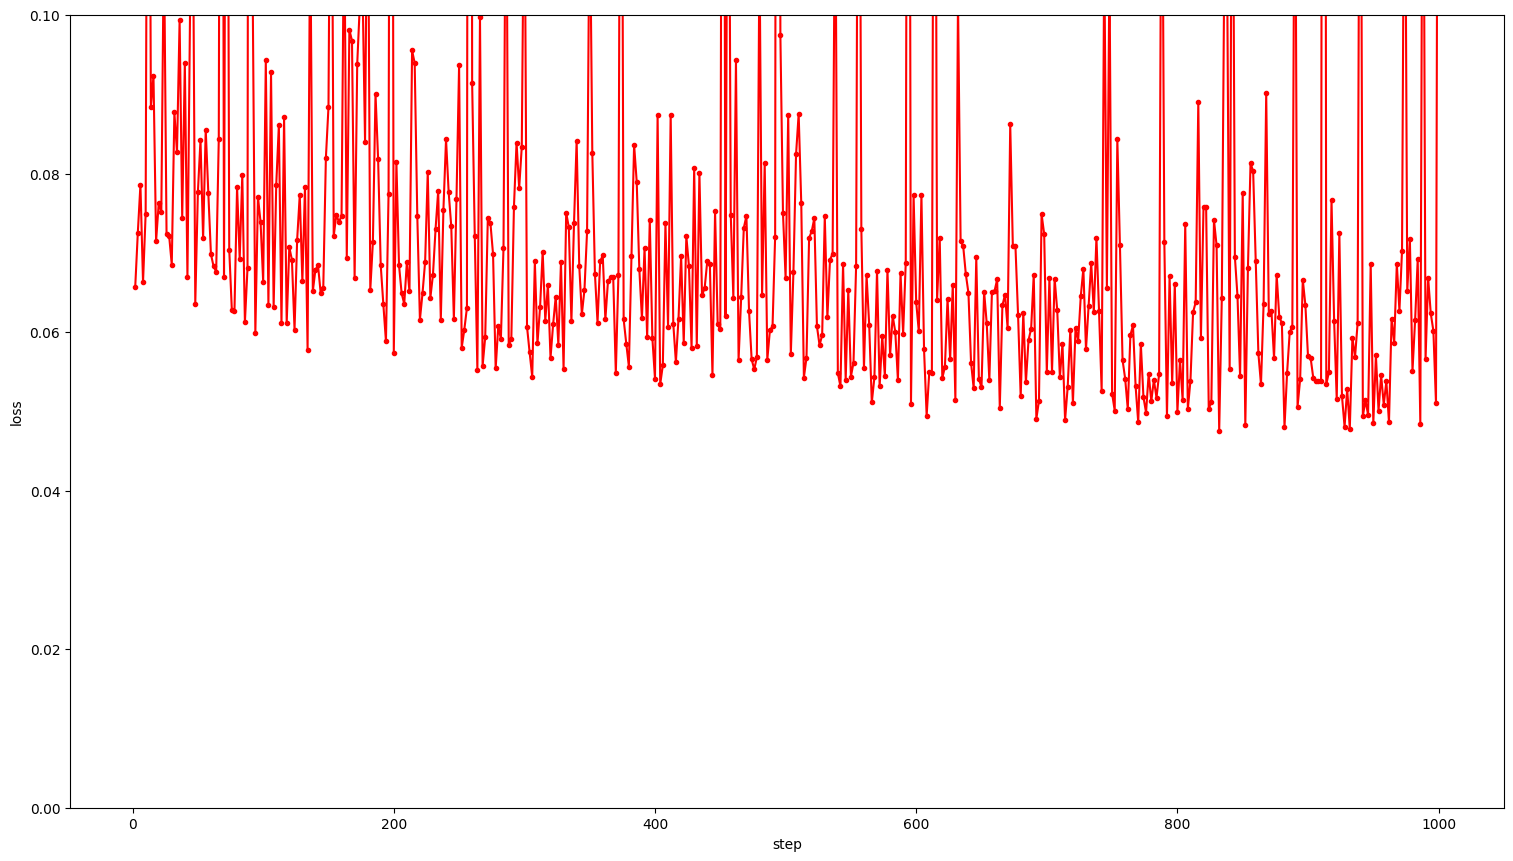

In [23]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
from tqdm import tqdm
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
"""
def print_metrics(metrics, epoch_samples, phase='train'):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def calc_loss(pred,target,metrics,bce_weight=0.5) :
    #bce = F.binary_cross_entropy_with_logits(pred,target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred,target) 

    #loss = bce * bce_weight + dice * (1 - bce_weight)
    

    metrics['bce'] += 1#bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += 1#loss.data.cpu().numpy() * target.size(0)

    return metrics['loss']
"""
"""
def dice_coef_binary_4cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 4 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = torch.flatten(F.one_hot(torch.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = torch.flatten(y_pred[...,1:])
    intersect = F.sum(y_true_f * y_pred_f, axis=-1)
    denom = F.sum(y_true_f + y_pred_f, axis=-1)
    return F.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary_4cat(y_true, y_pred)

"""
checkpoint_path = "checkpoint.pth"
data_path = '/content/drive/MyDrive/data/train/'
num_workers = 2
batch_size = 2
"""
#what does data loader do?
Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

"""

def train_net(model,
              device,
              epochs: int =10,
              batch_size: int = 1,
              learning_rate: float = 0.000001,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
#print("training the network...")
# Fetch images and labels.
  model.train()  #funciton of the module superclass ..sets the model to train.
  train_set = TrainDataset(data_path)
  training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
 # https://github.com/milesial/Pytorch-UNet/blob/master/train.py 

  optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  criterion = nn.CrossEntropyLoss()
  if isinstance(criterion,torch.nn.Module): ##just to be sure that criterion is on the correct device.
    criterion.to(device)
  global_step = 0
  steps =[]
  losses=[]
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    epoch_samples = 0
    epoch_loss=0
    metrics = defaultdict(float)
    since = time.time()
  
    with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
      for iteration, sample in enumerate(training_data_loader):
          img, mask = sample
          img=img.unsqueeze(0)
          img  = img.to(device = device)
          #https://discuss.pytorch.org/t/only-batches-of-spatial-targets-supported-non-empty-3d-tensors-but-got-targets-of-size-1-1-256-256/49134/18 
          mask = mask.squeeze(1)
          mask = mask.to(device,dtype = torch.long)

      
          #mask = F.one_hot(mask,4).permute(0,3,1,2).float()
          #print(mask.shape)
          """
          torch.cuda.amp and torch provide convenience methods for mixed precision,
          where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
          Some ops, like linear layers and convolutions, are much faster in float16. 
          Other ops, like reductions, often require the dynamic range of float32. 
          Mixed precision tries to match each op to its appropriate datatype.
          """
          #with torch.cuda.amp.autocast(enabled = amp)
          out  = model(img)
          #print(out.shape)
          cross_entropy_loss = criterion (out,mask) 
          #dice_loss = dice_coef_binary_loss(mask,out)
          dice= dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
          loss = cross_entropy_loss + dice
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          optimizer.zero_grad(set_to_none=True)
          grad_scaler.scale(loss).backward()
          grad_scaler.step(optimizer)
          grad_scaler.update()

          pbar.update(img.shape[0])
          global_step += 1
          epoch_loss += loss.item()
          losses.append(loss.item())
          steps.append(global_step)

          #experiment.log({
           #         'train loss': loss.item(),
            #        'step': global_step,
             #       'epoch': epoch
               # })
          print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
          pbar.set_postfix(**{'loss (batch)': loss.item()})
  plt.plot(steps[1::2],losses[1::2],'.r-')
  plt.xlabel("step")
  plt.ylabel("loss")
  x1,x2,y1,y2 = plt.axis()  
  plt.axis((x1,x2,0,0.1))
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  fig.set_dpi(100)
  plt.show()
  return model
model = train_net(model,device)
torch.save(model.state_dict(), checkpoint_path)

    

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable
print(os.getcwd())

/content


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

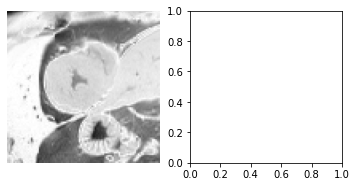

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = '/content/drive/MyDrive/data/test/'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

for iteration, sample in enumerate(test_data_loader):
    img = sample
    #print(img.shape)
    x = torch.nn.Conv2d(2, 1, 1) 
    img = img.unsqueeze(0)
    img = x(img)

    img = img.to(device)
    out = model(img)
    #plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    #plt.pause(1)
    plt.subplot(1, 2, 1)
    plt.imshow(img[0,...].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(out.detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()